In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import entropy
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import os

sys.path.append(os.path.abspath(".."))


SEED = 16

data=np.load("../datasets/labeled/first_batch_multi_labels.npz")
data2=np.load("../datasets/labeled/second_batch_multi_labels.npz")
data3=np.load("../datasets/labeled/third_batch_multi_labels.npz")

X1=data["X"]
y1=data["y"]

X2=data2["X"]
y2=data2["y"]

X3=data3["X"]
y3=data3["y"]

X=np.concatenate((X1,X2,X3),axis=0)
y=np.concatenate((y1,y2,y3),axis=0)

XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
yy.rename(columns={0:"user",1:"label"},inplace=True)

# Merge labels into main dataset
XX = XX.merge(yy, on="user", how="left").sort_values(by=["user", "item"]).reset_index(drop=True)

print(XX.shape)
XX.head()

(524883, 4)


,user,item,rating,label
0,0,9,0,0
1,0,12,10,0
2,0,13,10,0
3,0,15,10,0
4,0,16,1,0


In [2]:
from utils.feature_transformation import aggregate_features

user_features = aggregate_features(XX)
user_features = user_features.merge(yy, on="user", how="left")
print(user_features.shape)
# user_features.to_csv("user_features.csv", index=False)
user_features.head()


(3300, 85)


c:\Users\juski\Desktop\CS421 Principles of Machine Learning\cs421-project\utils\feature_transformation.py:203: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  item_rating_skew=("rating", lambda x: skew(x.dropna())),


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,max_item_review_count,min_item_review_count,item_mean_vs_user_avg,item_skew_bias,normalized_movie_popularity,popularity_skew,rating_polarity,activity_weighted_skew,switch_pct,label
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,2341,59,-3.066024,-0.437554,1.0,2282,0.565476,-2.817185,0.714286,0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,2367,34,-0.082865,-0.454684,1.0,2333,0.288462,-1.703270,0.740385,0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,2367,73,1.954071,-0.449163,1.0,2294,0.071795,-1.356825,0.805128,3
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,2172,182,2.567873,-0.533277,1.0,1990,0.073171,-0.522866,0.634146,0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,1989,411,-3.739258,-0.500907,1.0,1578,0.666667,-1.449192,0.833333,0


In [3]:
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

df = user_features.copy()

# TODO: To achieve the best result, need to select the best features based on SHAP. Just uncomment this code to get the highest AUC so far.
# # SHAP-guided feature filtering
# keep = set([
#     "user", "label",
#     'unknown_pct', 'min_movie', 'z_rating_median',
#        'popularity_vs_deviation', 'gap_mean', 'mean_rating_diff',
#        'std_movie_popularity', 'std_deviation', 'max_movie', 'average_product',
#        'max_abs_rating_diff', 'std_rating', 'likes_rare', 'variance_movie',
#        'avg_rating', 'min_movie_popularity', 'like_dislike_ratio', 'gap_max',
#        'rare_movies_watched_pct', 'rare_like_ratio', 'median_movie',
#        'dislike_pct', 'mean_abs_deviation', 'max_movie_popularity',
#        'user_pop_percentile_std', 'rating_entropy', 'z_rating_max',
#        'max_abs_deviation', 'sum_item_rating'
# ])
# df = df[[col for col in df.columns if col in keep]]

print(df.shape)
df.head()

(3300, 85)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,max_item_review_count,min_item_review_count,item_mean_vs_user_avg,item_skew_bias,normalized_movie_popularity,popularity_skew,rating_polarity,activity_weighted_skew,switch_pct,label
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,2341,59,-3.066024,-0.437554,1.0,2282,0.565476,-2.817185,0.714286,0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,2367,34,-0.082865,-0.454684,1.0,2333,0.288462,-1.703270,0.740385,0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,2367,73,1.954071,-0.449163,1.0,2294,0.071795,-1.356825,0.805128,3
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,2172,182,2.567873,-0.533277,1.0,1990,0.073171,-0.522866,0.634146,0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,1989,411,-3.739258,-0.500907,1.0,1578,0.666667,-1.449192,0.833333,0


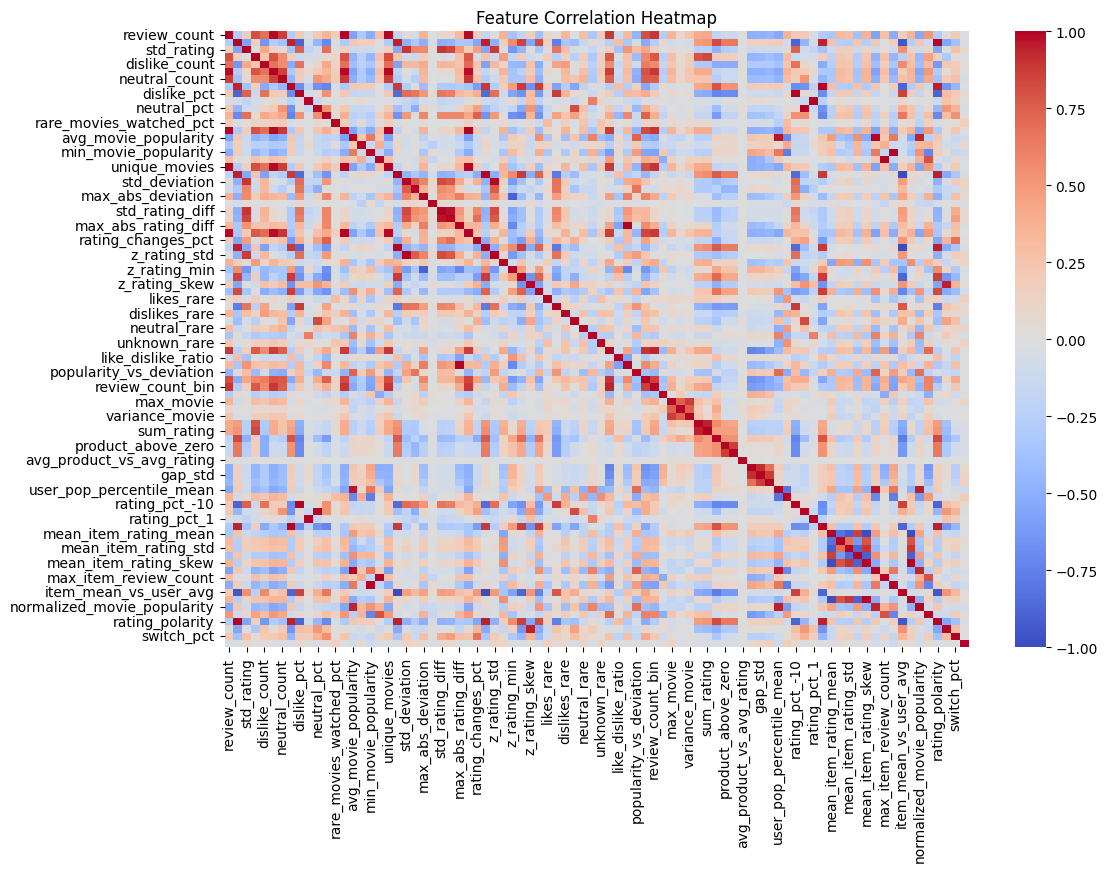

Dropped correlated features: {'normalized_movie_popularity', 'rating_changes_count', 'rating_range', 'rating_pct_1', 'user_pop_percentile_mean', 'z_rating_mean', 'z_rating_std', 'sum_rating', 'like_pct', 'mean_item_rating_std', 'activity_weighted_skew', 'item_skew_bias', 'unknown_count', 'rating_polarity', 'entropy_by_count', 'gap_std', 'item_mean_vs_user_avg', 'mean_abs_rating_diff', 'rating_pct_10', 'change_direction_count', 'max_item_review_count', 'rating_pct_0', 'rating_pct_-10', 'unique_movies', 'mean_item_rating_skew', 'mean_deviation', 'z_rating_min', 'mean_item_review_count', 'min_item_review_count', 'review_count_bin'}


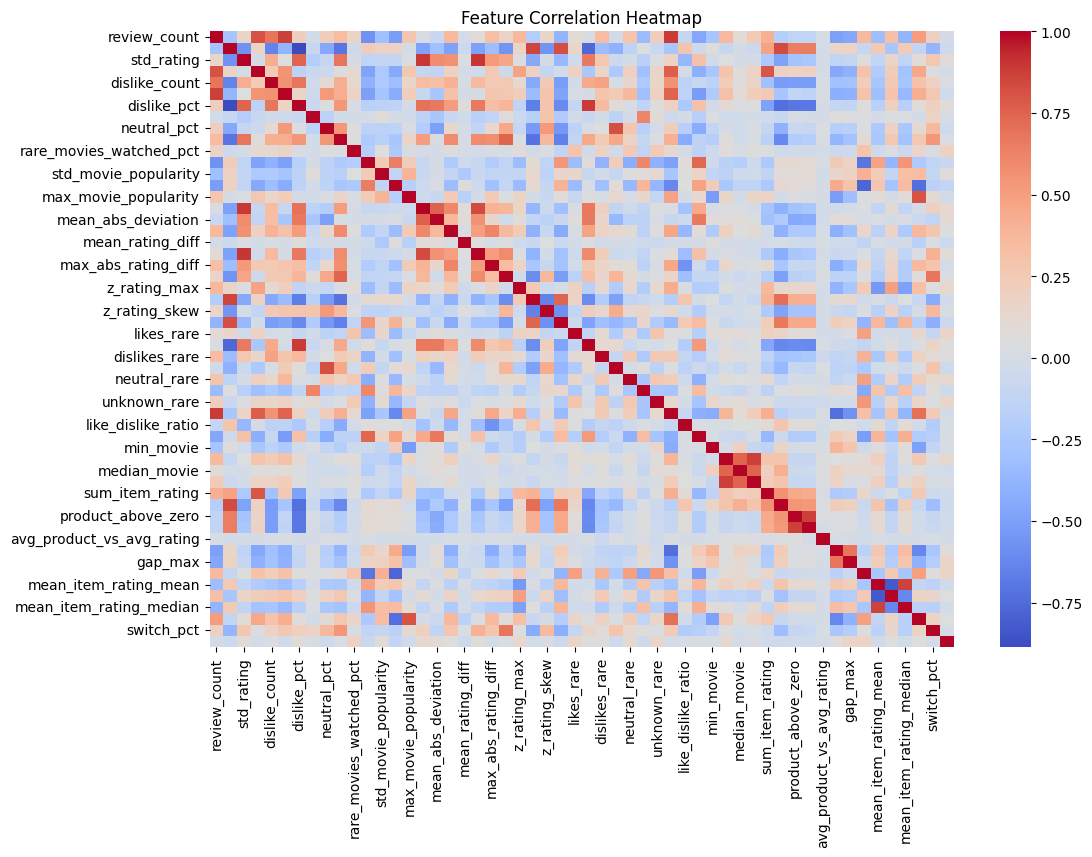

In [4]:
df.drop(columns=["user"], inplace=True)
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

correlated_features = set()
threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df.drop(columns=correlated_features, inplace=True, errors="ignore")
print(f"Dropped correlated features: {correlated_features}")

correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

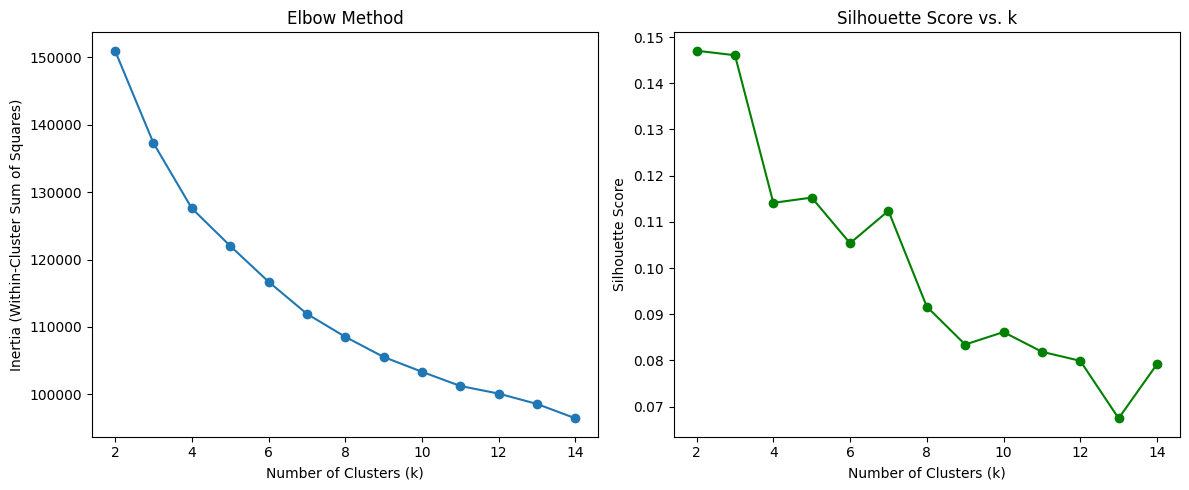

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. Drop non-numeric columns & labels before clustering
features_for_clustering = df.drop(columns=["label"], errors='ignore')

# 2. Fill NA (just in case) and scale
X_scaled = StandardScaler().fit_transform(features_for_clustering.fillna(0))

# 3. Elbow method: Try KMeans for different k values
inertias = []
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)

# 4. Plot Inertia (Elbow Curve)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method")

# 5. Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. k")

plt.tight_layout()
plt.show()


In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse preprocessed data
X_scaled = StandardScaler().fit_transform(
    user_features.drop(columns=["user", "label"], errors="ignore").fillna(0)
)

# Fit KMeans with k=2
kmeans = KMeans(n_clusters=6, random_state=SEED, n_init="auto")
user_features["cluster"] = kmeans.fit_predict(X_scaled)


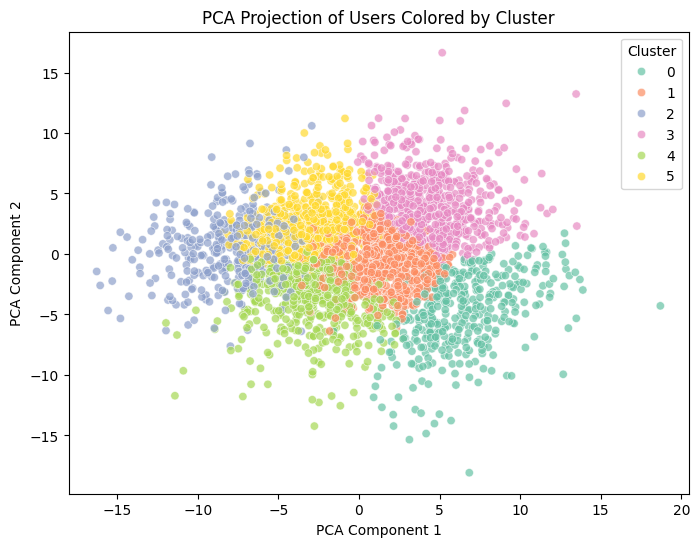

In [10]:
# Reduce to 2D for plotting
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

user_features["pca_1"] = pca_result[:, 0]
user_features["pca_2"] = pca_result[:, 1]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_features,
    x="pca_1",
    y="pca_2",
    hue="cluster",
    palette="Set2",
    alpha=0.7
)
plt.title("PCA Projection of Users Colored by Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()
